In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
Image(url= "https://cdn-images-1.medium.com/max/1600/1*UkI9za9zTR-HL8uM15Wmzw.png")


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# hyperparams
num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [3]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0
    
    x = x.reshape((batch_size, -1))
    y = y.reshape((batch_size, -1))
    
    return (x, y)

data = generateData()
print (data)
    

(array([[1, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 0, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 1, 0, 1]]))


In [4]:
#Light-gray rectangle represent a “zero” and dark-gray a “one”.
Image(url= "https://cdn-images-1.medium.com/max/1600/1*aFtwuFsboLV8z5PkEzNLXA.png")

In [16]:
# step 2 - build model
# placeholder - what we feed our data into
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

# state learned before
init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [43]:
# weights
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1, state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [44]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*n45uYnAfTDrBvG87J-poCA.jpeg")

In [45]:
# inputs_series = tf.unstack(batchX_placeholder, axis=1)
# labels_series = tf.unstack(batchY_placeholder, axis=1)

inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [46]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*f2iL4zOkBUBGOpVE7kyajg.png")

In [49]:
# forward pass - activation: tanh -> rnn
# sigmoid - output probablilites - last layer b/w 0 and 1
current_state = init_state
states_series = []
    
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state = tf.concat([current_input, current_state], 1)
    next_state = tf.tanh(tf.matmul(input_and_state, W) + b)
    states_series.append(next_state)
    current_state = next_state

In [50]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fdwNNJ5UOE3Sx0R_Cyfmyg.png")

In [57]:
# calc loss and minimize (learning)
# logits => logistic transform
# adagrad => sparse features but important. gives more weight to sparse features
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series, labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [58]:
# visualizer
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

In [67]:
# training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion() # interactive mode
    plt.figure() # init figure
    plt.show() # show graph
    loss_list = [] 
    
    for epoch_idx in range(num_epochs):
        x, y = generateData()
        
        _current_state = np.zeros((batch_size, state_size))
        print("new data, epoch", epoch_idx)
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            
            batchX = x[:, start_idx: end_idx]
            batchY = y[:, start_idx: end_idx]
            
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                    [total_loss, train_step, current_state, predictions_series],
                    feed_dict = {
                        batchX_placeholder: batchX,
                        batchY_placeholder: batchY,
                        init_state: _current_state

                    })
            
            loss_list.append(_total_loss)
            
            if batch_idx % 100 == 0:
                print ("Step", batch_idx, "loss", _total_loss)

        
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

new data, epoch 0
Step 0 loss 0.7156038
Step 100 loss 0.6941498
Step 200 loss 0.6902418
Step 300 loss 0.6978881
Step 400 loss 0.70454144
Step 500 loss 0.69314075
Step 600 loss 0.69401515
new data, epoch 1
Step 0 loss 0.7054465
Step 100 loss 0.6955715
Step 200 loss 0.6891651
Step 300 loss 0.6911762
Step 400 loss 0.6965523
Step 500 loss 0.6954762
Step 600 loss 0.69545245
new data, epoch 2
Step 0 loss 0.68819183
Step 100 loss 0.6936332
Step 200 loss 0.6884604
Step 300 loss 0.70913357
Step 400 loss 0.6902231
Step 500 loss 0.6934483
Step 600 loss 0.67997783
new data, epoch 3
Step 0 loss 0.68986565
Step 100 loss 0.69775325
Step 200 loss 0.69261986
Step 300 loss 0.6937273
Step 400 loss 0.69869685
Step 500 loss 0.6886047
Step 600 loss 0.692155
new data, epoch 4
Step 0 loss 0.6935715
Step 100 loss 0.6946508
Step 200 loss 0.6936419
Step 300 loss 0.68912584
Step 400 loss 0.6947841
Step 500 loss 0.6923422
Step 600 loss 0.6919298
new data, epoch 5
Step 0 loss 0.6853694
Step 100 loss 0.68237394
Step

Step 100 loss 0.69130903
Step 200 loss 0.6933091
Step 300 loss 0.6906273
Step 400 loss 0.6928854
Step 500 loss 0.692888
Step 600 loss 0.69401824
new data, epoch 45
Step 0 loss 0.69527274
Step 100 loss 0.6957642
Step 200 loss 0.6912899
Step 300 loss 0.6953154
Step 400 loss 0.69557136
Step 500 loss 0.6928703
Step 600 loss 0.6932267
new data, epoch 46
Step 0 loss 0.6947894
Step 100 loss 0.69267315
Step 200 loss 0.6932123
Step 300 loss 0.690267
Step 400 loss 0.6940342
Step 500 loss 0.6934042
Step 600 loss 0.6938291
new data, epoch 47
Step 0 loss 0.6933904
Step 100 loss 0.69157946
Step 200 loss 0.69343895
Step 300 loss 0.6907503
Step 400 loss 0.6915506
Step 500 loss 0.6915998
Step 600 loss 0.6923852
new data, epoch 48
Step 0 loss 0.68941146
Step 100 loss 0.69234246
Step 200 loss 0.6930127
Step 300 loss 0.6915333
Step 400 loss 0.69419026
Step 500 loss 0.69241464
Step 600 loss 0.69601095
new data, epoch 49
Step 0 loss 0.6950576
Step 100 loss 0.69067854
Step 200 loss 0.69373375
Step 300 loss 0

Step 200 loss 0.6961269
Step 300 loss 0.68736494
Step 400 loss 0.69324017
Step 500 loss 0.6931425
Step 600 loss 0.6930939
new data, epoch 89
Step 0 loss 0.68800384
Step 100 loss 0.69488007
Step 200 loss 0.69189155
Step 300 loss 0.69469553
Step 400 loss 0.69561535
Step 500 loss 0.6944199
Step 600 loss 0.693277
new data, epoch 90
Step 0 loss 0.6913502
Step 100 loss 0.6934216
Step 200 loss 0.69132763
Step 300 loss 0.6901971
Step 400 loss 0.69104767
Step 500 loss 0.6949286
Step 600 loss 0.69304013
new data, epoch 91
Step 0 loss 0.690023
Step 100 loss 0.6925031
Step 200 loss 0.6932967
Step 300 loss 0.6923821
Step 400 loss 0.6925172
Step 500 loss 0.69465905
Step 600 loss 0.69290376
new data, epoch 92
Step 0 loss 0.68755007
Step 100 loss 0.6934111
Step 200 loss 0.6976405
Step 300 loss 0.69309205
Step 400 loss 0.6890598
Step 500 loss 0.6939443
Step 600 loss 0.6934911
new data, epoch 93
Step 0 loss 0.68219817
Step 100 loss 0.69758874
Step 200 loss 0.69331545
Step 300 loss 0.6934104
Step 400 los

In [64]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*uKuUKp_m55zAPCzaIemucA.png")

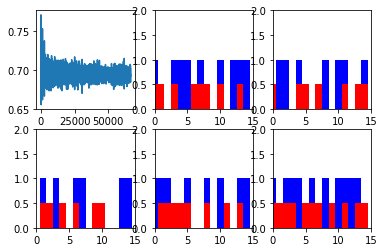

In [68]:
plot(loss_list, _predictions_series, batchX, batchY)